In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import keras
# from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [0]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 32
epochs = 20

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Processing dataset

In [5]:
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("/content/gdrive/My Drive/WeekSeven/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [0]:
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

In [0]:
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
	      print("",end="")


In [8]:
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [9]:
# Convert from 7 columns to 1 column
Y_train, Y_test = [], []
for i in range(y_train.shape[0]):
  for j in range(7):
    if 1 == y_train[i][j]:
      Y_train.append(j)

for i in range(y_test.shape[0]):
  for j in range(7):
    if 1 == y_test[i][j]:
      Y_test.append(j)  

Y_train = np.array(Y_train, 'float32')
Y_test = np.array(Y_test, 'float32')
Y_test.shape, Y_train.shape, Y_train[51], Y_test[101]  

((3589,), (28709,), 5.0, 6.0)

In [0]:
#construct CNN structure
def CNNd():
    model = tf.keras.models.Sequential([
            #1st convolution layer
            Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1),padding='same'),
            MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
            BatchNormalization(),

            #2nd convolution layer
            Conv2D(128, (3, 3), activation='relu',padding='same'),
            Conv2D(128, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            #3rd convolution layer
            Conv2D(256, (3, 3), activation='relu',padding='same'),
            Conv2D(256, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            #4th convolution layer
            Conv2D(512, (3, 3), activation='relu',padding='same'),
            Conv2D(512, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            Flatten(),

            #fully connected neural networks
            Dense(4096, activation='relu'),
            Dropout(0.2),
            BatchNormalization(),

            Dense(1024, activation='relu'),
            Dropout(0.2),
            BatchNormalization(),

            Dense(num_classes, activation='softmax'),
            ])
    return model

modeld = CNNd()

In [0]:
#ImageDataGenerator for train
import math

gen = ImageDataGenerator()
train_generator = gen.flow(x_train, Y_train, batch_size=batch_size,shuffle=True)
test_generator = gen.flow(x_test, Y_test, batch_size=batch_size,shuffle=True)

num_steps_train = math.ceil(float(x_train.shape[0])/batch_size)
num_steps_val = math.ceil(float(x_test.shape[0])/batch_size)

In [0]:
#Compile model
modeld.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
#Fit model or load weights
fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	modeld.fit(train_generator, steps_per_epoch=num_steps_train, epochs=25, validation_data=test_generator, validation_steps=num_steps_val) #train for randomly selected one
else:
	modeld.load_weights('/data/facial_expression_model_weights.h5') #load weights

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 898 steps, validate for 113 steps
Epoch 1/25
898/898 [==============================] - 15s 16ms/step - loss: 2.0181 - accuracy: 0.2237 - val_loss: 1.8409 - val_accuracy: 0.2405
Epoch 2/25
898/898 [==============================] - 13s 14ms/step - loss: 1.8199 - accuracy: 0.2795 - val_loss: 1.8683 - val_accuracy: 0.2767
Epoch 3/25
898/898 [==============================] - 13s 14ms/step - loss: 1.6217 - accuracy: 0.3735 - val_loss: 2.1803 - val_accuracy: 0.2697
Epoch 4/25
898/898 [==============================] - 13s 14ms/step - loss: 1.4082 - accuracy: 0.4631 - val_loss: 1.4344 - val_accuracy: 0.4416
Epoch 5/25
898/898 [==============================] - 13s 14ms/step - loss: 1.2734 - accuracy: 0.5134 - val_loss: 1.3369 - val_accuracy: 0.4976
Epoch 6/25
898/898 [==============================] - 13s 14ms/step - loss: 1.1993 - accuracy: 0.5500 - val_loss: 1.2737 - val_accuracy: 0.5099
Epoch 7/25
898/898 [======================

In [0]:
modeld.save('/content/gdrive/My Drive/WeekSeven/emotiond.h5')

## Testing our model

In [64]:
!pip install google_images_download

     |████████████████████████████████| 911kB 52.8MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=67b0d49d84c463d74707ed26dfaf8f67c595e9ab6231267a7f2e419f62615ef1
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
import os
from google_images_download import google_images_download 
import sys

In [66]:
# the limit of google_images_download without chromedriver is 100 item per keywords 
response = google_images_download.googleimagesdownload()

arguments = [{"keywords"     : 'asian male disgust face',
             "limit"        : 5,
             "print_urls"   : True,
             "size"         : ">2MP",},
             
             {"keywords"     : 'asian female disgust face',
             "limit"        : 5,
             "print_urls"   : True,
             "size"         : ">2MP"}]
for argument in arguments: 
    paths = response.download(argument)


Item no.: 1 --> Item name = asian male disgust face
Evaluating...
Starting Download...
Image URL: https://marketplace.canva.com/MADaExVtxkE/1/screen_2x/canva-headshot-photo-of-asian-man-with-hate-and-disgusting-face.-on-grey-background.-MADaExVtxkE.jpg
Completed Image ====> 1.canva-headshot-photo-of-asian-man-with-hate-and-disgusting-face.-on-grey-background.-MADaExVtxkE.jpg
Image URL: https://st4.depositphotos.com/5192617/21296/i/1600/depositphotos_212968022-stock-photo-headshot-photo-asian-man-hate.jpg
Completed Image ====> 2.depositphotos_212968022-stock-photo-headshot-photo-asian-man-hate.jpg
Image URL: https://thumbs.dreamstime.com/z/funny-asian-man-lazy-bored-mocking-face-portrait-young-attractive-showing-disgust-unhappy-expression-145456178.jpg
Completed Image ====> 3.funny-asian-man-lazy-bored-mocking-face-portrait-young-attractive-showing-disgust-unhappy-expression-145456178.jpg
Image URL: https://video-images.vice.com/articles/5b5b68f8d736970006757f02/lede/1532721082758-wenw

In [0]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [0]:

monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


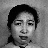

In [62]:
# We show how the library load our image
img = image.load_img("/content/gdrive/My Drive/WeekSeven/KA.DI2.43.tiff", grayscale=True, target_size=(48, 48))
img

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


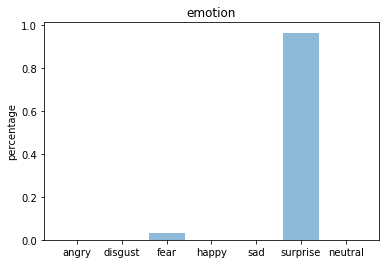

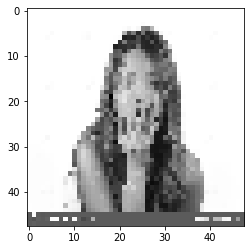

In [71]:
from tensorflow.keras.preprocessing import image

img = image.load_img("./downloads/asian female disgust face/5.portrait-young-shocked-surprised-beautiful-asian-korean-woman-covering-mouth-hand-disbelief-surprise-face-136248484.jpg", grayscale=True, target_size=(48, 48))
#Convert to array
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#Normalize
x /= 255
#Predict
custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

## Try a different model

Different models that we have tried

In [0]:
#construct CNN structure
def CNN():
    model = tf.keras.models.Sequential([
            #1st convolution layer
            Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)),
            MaxPooling2D(pool_size=(5,5), strides=(2, 2)),

            #2nd convolution layer
            Conv2D(64, (3, 3), activation='relu'),
            Conv2D(64, (3, 3), activation='relu'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),

            #3rd convolution layer
            Conv2D(128, (3, 3), activation='relu'),
            Conv2D(128, (3, 3), activation='relu'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),

            Flatten(),

            #fully connected neural networks
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),

            Dense(num_classes, activation='softmax'),
            ])
    return model

model = CNN()

In [0]:
def CNNb():
    model = tf.keras.models.Sequential([
            #1st convolution layer
            Conv2D(64, (3, 3), activation='relu', input_shape=(48,48,1)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2, 2)),

            #2nd convolution layer
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2, 2)),

            #3rd convolution layer
            Conv2D(256, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2, 2)),
       
            #fully connected neural networks
            Dropout(0.2),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            BatchNormalization(),

            Dense(num_classes, activation='softmax'),
            ])
    return model

modelb = CNNb()

In [0]:
#Compile model
modelb.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
modelb.fit(train_generator, steps_per_epoch=num_steps_train, epochs=20, validation_data=test_generator, validation_steps=num_steps_val) #train for randomly selected one
